# Optimising almost-Clifford circuits

In this Notebook we will produce some comparisons for how the PyZX Clifford simplification procedure fairs in comparison to more naive approaches.

First we import all the necessary libraries

In [2]:
import sys; sys.path.append('..')
import random, math, os
import pyzx as zx
from fractions import Fraction
import numpy as np
%config InlineBackend.figure_format = 'svg'
zx.quantomatic.quantomatic_location = r'C:\Users\John\Desktop\Quantomatic.jar'
zx.tikz.tikzit_location = r'C:\Users\John\Documents\tikzit\tikzit.exe'

Now we define some useful functions for generating our data and optimizing circuits

In [3]:
def generate_clifford_circuit(qubits, depth, p_had, p_s):
    p_cnot = 1-p_had-p_s
    c = zx.Circuit(qubits)
    for _ in range(depth):
        r = random.random()
        if r > 1-p_had:
            c.add_gate("HAD",random.randrange(qubits))
        elif r > 1-p_had-p_s:
            c.add_gate("S",random.randrange(qubits))
        else:
            tgt = random.randrange(qubits)
            while True:
                ctrl = random.randrange(qubits)
                if ctrl!=tgt: break
            c.add_gate("CNOT",tgt,ctrl)
    return c

In [4]:
def opt_circuit(c):
    g = c.to_graph()
    zx.simplify.interior_clifford_simp(g,quiet=True)
    c2 = zx.extract.streaming_extract(g)
    return zx.optimize.basic_optimization(c2.to_basic_gates()).to_basic_gates()

In [5]:
def generate_dataset(qubits,depth,layers,t_prob,reps=50):
    """Generates a set of `reps` circuits consisting of `layers` amount of Clifford circuits,
    interspersed with T gates that appear with probability `t_prob` on every qubit.
    Each Clifford layer has `depth` amount of gates."""
    stats = []
    for _ in range(reps):
        c = zx.Circuit(qubits)
        c_opt_part = zx.Circuit(qubits)
        for __ in range(layers):
            cliff = generate_clifford_circuit(qubits,depth,0.15,0.2)
            c.add_circuit(cliff)
            c_opt_part.add_circuit(opt_circuit(cliff))
            for i in range(qubits):
                if random.random() > 1-t_prob:
                    c.add_gate("T",i)
                    c_opt_part.add_gate("T",i)
        c_opt = zx.optimize.basic_optimization(c).to_basic_gates()
        c2_opt = opt_circuit(c)
        c_opt_part = zx.optimize.basic_optimization(c_opt_part).to_basic_gates()
        stats.append((c.twoqubitcount(),c_opt.twoqubitcount(),c_opt_part.twoqubitcount(),c2_opt.twoqubitcount()))

    sums = [0,0,0,0]
    for a,b,c,d in stats:
        sums[0] += a
        sums[1] += b
        sums[2] += c
        sums[3] += d
    
    return (sums[0]/reps,sums[1]/reps,sums[2]/reps,sums[3]/reps)

Now we generate some data comparing the different optimization methods when we vary the gate count per Clifford block

In [142]:
xs = [0.6+0.15*i for i in range(9)]

yys = [[],[],[],[]]
qubits = 10
layers = 5
t_prob = 0.8
reps = 60
for x in xs:
    print(x, end='.')
    depth = int(x*qubits**2)
    for i,y in enumerate(generate_dataset(qubits,depth,layers,t_prob,reps)):
        yys[i].append(y)

0.6.0.75.0.8999999999999999.1.0499999999999998.1.2.1.35.1.5.1.65.1.7999999999999998.

And now we plot the resulting data

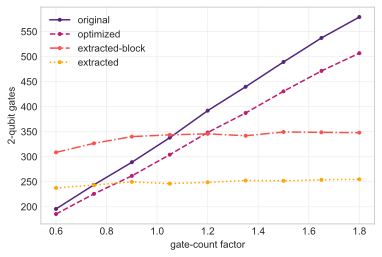

In [152]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.style.use('seaborn-whitegrid')

fig = plt.figure()
ax1 = fig.add_subplot(111)

colours = ['#53257f', '#bc1b73', '#f8534a', '#ffa600']
names = ['original','optimized','extracted-block', 'extracted']
styles = ['-','--','-.',':']
for i, ys in enumerate(yys):
    ax1.plot(xs, ys, c=colours[i], marker="o",markersize=3, linestyle=styles[i], label=names[i])

ax1.set_ylabel("2-qubit gates")
ax1.set_xlabel("gate-count factor")

plt.legend(loc='upper left');
plt.grid(color='#EEEEEE')
plt.show()

As can be seen, both of the extraction methods, the one that only acts on the block of Cliffords, and the full extraction, saturate in the amount of 2-qubit gates, but the full extraction saturates at a much lower total gate count, showing that it indeed performs better than naive Clifford optimization.

In [154]:
fig.savefig(r'C:\Users\John\Documents\Projects\cliff-simp\graphics\gatecount-comparison.pdf',bbox_inches='tight')

We can also study the dependence of the performance of our method with respect to the density of T gates between the layers of Cliffords. We do this by varying the probability of a T gate appearing:

In [6]:
xs = [0.2,0.4,0.6,0.7,0.8,0.9,0.95,1.0]

yys = [[],[],[],[]]
qubits = 10
layers = 5
depth = 100
reps = 60
for x in xs:
    print(x, end='.')
    t_prob = x
    for i,y in enumerate(generate_dataset(qubits,depth,layers,t_prob,reps)):
        yys[i].append(y)

0.2.0.4.0.6.0.7.0.8.0.9.0.95.1.0.

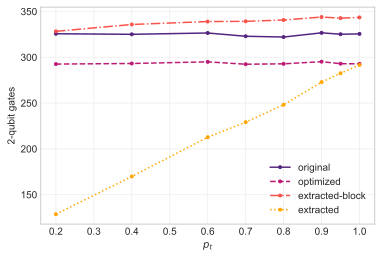

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.style.use('seaborn-whitegrid')

fig = plt.figure()
ax1 = fig.add_subplot(111)

colours = ['#53257f', '#bc1b73', '#f8534a', '#ffa600']
names = ['original','optimized','extracted-block', 'extracted']
styles = ['-','--','-.',':']
for i, ys in enumerate(yys):
    ax1.plot(xs, ys, c=colours[i], marker="o",markersize=3, linestyle=styles[i], label=names[i])

ax1.set_ylabel("2-qubit gates")
ax1.set_xlabel("$p_t$")

plt.legend(loc='lower right');
plt.grid(color='#EEEEEE')
plt.show()

As can be seen, as the amount of T gates between the layers increases, the full method starts performing more comparably to the block extraction method. This is to be expected as the T gates act as obstructions to our simplification method.